<a href="https://colab.research.google.com/github/Akash-nitA/Akash-nitA/blob/main/creditcard_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fetch Data and import necessary libraries

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 

--2022-02-07 18:33:46--  https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 64.233.167.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 150828752 (144M) [text/csv]
Saving to: ‘creditcard.csv.1’

creditcard.csv.1    100%[===================>] 143.84M   175MB/s    in 0.8s    

2022-02-07 18:33:47 (175 MB/s) - ‘creditcard.csv.1’ saved [150828752/150828752]



In [ ]:
data = pd.read_csv("creditcard.csv")

# Visualize the data

1. plot a countplot to check for imbalance in the Dataset

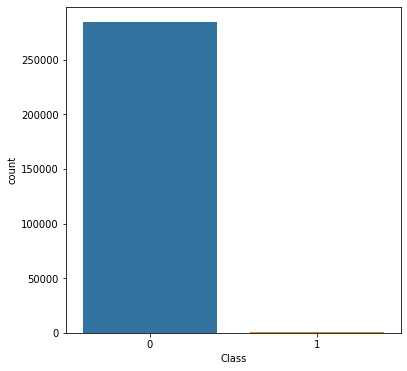

In [ ]:
plt.figure(figsize=(6,6))
sb.countplot(x="Class",data=data)
plt.show()

2. check for skewness in the data. If skewness is present than we should apply necessary transfromations

<Figure size 864x576 with 0 Axes>

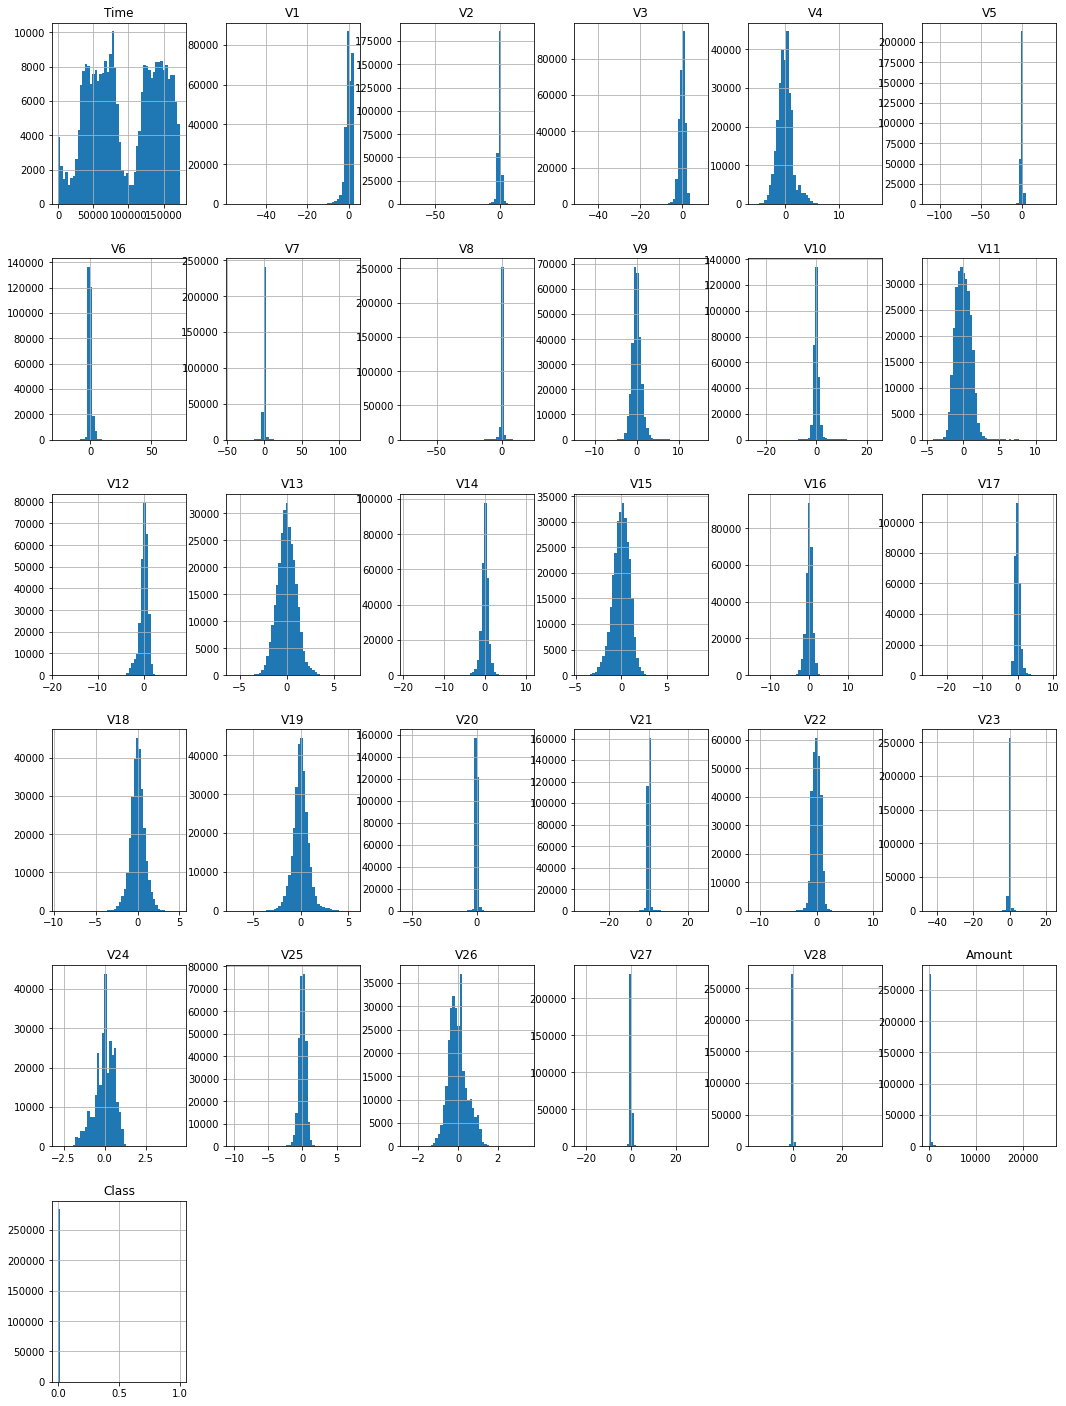

In [ ]:
plt.figure(figsize=(12,8))
variables = [x for x in data.columns]
Skewnesss =  data[variables].skew()
data.hist(bins=50, figsize=(18,25))
plt.show()

# Log Transformation 

In [ ]:
df = data.copy()
df['Amount'] = [0.001+x for x in data['Amount']]
df['Amount'] = np.log10(df['Amount'])
df = df.drop(['Time'], axis =1)

# Train Test Split

In [ ]:
y=df['Class']
x=df.drop('Class',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=True)
x_test,x_validation,y_test,y_validation=train_test_split(x_test,y_test,test_size=0.2,shuffle=True)

# Standardize

In [ ]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)
x_validation=sc.transform(x_validation)

# clipping the data

In [ ]:
x_train=np.clip(x_train,-5,5)
x_test=np.clip(x_test,-5,5)
x_validation=np.clip(x_validation,-5,5)

# Seperate the dataset based on class

In [ ]:
y_train=np.expand_dims(y_train,axis=1)
dataset=np.append(x_train,y_train,axis=1)
dataset=pd.DataFrame(dataset,columns=df.columns)
dataframe0=dataset[dataset['Class']==0]
dataframe1=dataset[dataset['Class']==1]

# joint plot

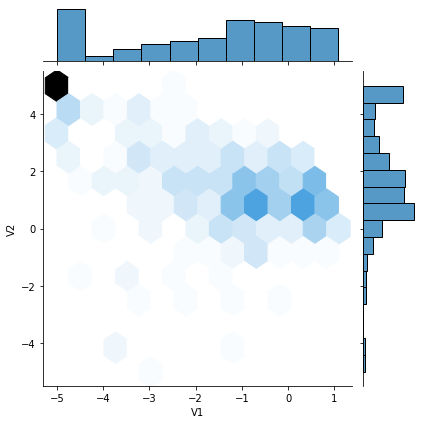

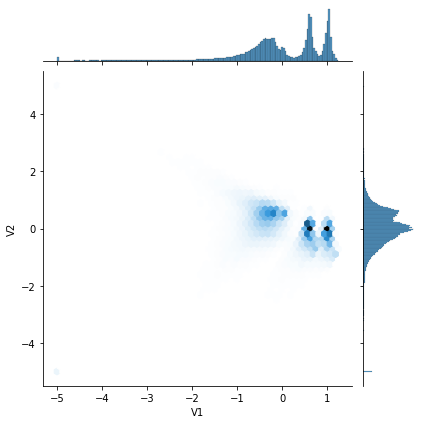

In [ ]:
sb.jointplot(data=dataframe1,x="V1",y="V2",kind='hex')
plt.show()
sb.jointplot(data=dataframe0,x="V1",y="V2",kind='hex')
plt.show()

# Build model

In [ ]:
metric=['AUC','Precision','Recall',
        'TruePositives','TrueNegatives',
        'FalsePositives','FalseNegatives','accuracy']

bias=np.log(dataframe1.shape[0]/dataframe0.shape[0])

def probitmodel():
  model=Sequential()
  model.add(Dense(8,activation='relu',input_shape=(29,),bias_initializer=tf.keras.initializers.Constant(bias)))
  model.add(Dropout(0.3))
  model.add(Dense(1,activation='sigmoid',kernel_regularizer='l2'))
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metric)
  model.summary()
  return model
  

# Train the model

In [ ]:
m=probitmodel()
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=1)
m.evaluate(x_test[:10],y_test[:10])
history_0=m.fit(x_train,y_train,validation_data=[x_test,y_test],callbacks=callback,epochs=20)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 240       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 3s 3s/step - loss: 0.7073 - auc: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 10.0000 - false_positives: 0.0000e+00 - false_negatives: 0.0000e+00 - accuracy: 1.0000
Epoch 1/20
7121/7121 [==============================] - 81s 

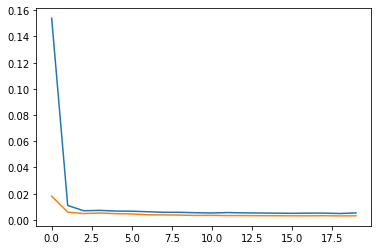

In [ ]:
plt.plot(history_0.history['loss'])
plt.plot(history_0.history['val_loss'])
plt.show()

In [ ]:
result_matrix1=m.evaluate(x_test,y_test,return_dict=True)
result_matrix1=pd.DataFrame(result_matrix1,index=[0])
result_matrix1

1425/1425 [==============================] - 11s 8ms/step - loss: 0.0031 - auc: 0.9491 - precision: 0.8871 - recall: 0.6962 - true_positives: 55.0000 - true_negatives: 45483.0000 - false_positives: 7.0000 - false_negatives: 24.0000 - accuracy: 0.9993


,loss,auc,precision,recall,true_positives,true_negatives,false_positives,false_negatives,accuracy
0,0.003071,0.949132,0.887097,0.696203,55.0,45483.0,7.0,24.0,0.99932


# Train the model with class weights

In [ ]:
m1=probitmodel()
classweight_0=len(x)/(2*len(y[y==0]))
classweight_1=len(x)/(2*len(y[y==1]))
classweight={0:classweight_0,1:classweight_1}
history_1=m1.fit(x_train,y_train,validation_data=[x_test,y_test],callbacks=callback,epochs=20,class_weight=classweight)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 240       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 249
Trainable params: 249
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
7121/7121 [==============================] - 68s 9ms/step - loss: 0.6847 - auc: 0.5298 - precision: 0.0019 - recall: 0.4495 - true_positives: 178.0000 - true_negatives: 134090.0000 - false_positives: 93359.0000 - false_negatives: 218.0000 - accuracy: 0.5893 - val_loss: 0.6689 - val_auc: 0.9249 - val_precisio

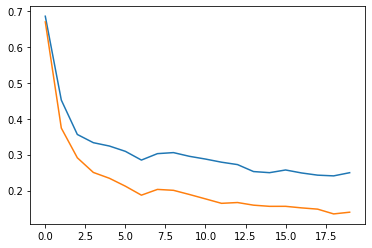

In [ ]:
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.show()

In [ ]:
result_matrix2=m1.evaluate(x_test,y_test,return_dict=True)
result_matrix2=pd.DataFrame(result_matrix1,index=[0])
result_matrix2

1425/1425 [==============================] - 10s 7ms/step - loss: 0.1400 - auc: 0.9682 - precision: 0.1759 - recall: 0.9241 - true_positives: 73.0000 - true_negatives: 45148.0000 - false_positives: 342.0000 - false_negatives: 6.0000 - accuracy: 0.9924


,loss,auc,precision,recall,true_positives,true_negatives,false_positives,false_negatives,accuracy
0,0.003071,0.949132,0.887097,0.696203,55.0,45483.0,7.0,24.0,0.99932


# Oversampling the minority class

oversampling the minority class using SMOTE function that uses KNN approach

In [ ]:
sampler=SMOTE(sampling_strategy='minority')
x_resampled,y_resampled=sampler.fit_resample(x_train,y_train)

In [ ]:
m2=probitmodel()
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=1)
m2.evaluate(x_test[:10],y_test[:10])
history_2=m2.fit(x_resampled,y_resampled,validation_data=[x_test,y_test],callbacks=callback,epochs=20,class_weight=classweight)

In [ ]:
result_matrix3=m2.evaluate(x_test,y_test,return_dict=True)
result_matrix3=pd.DataFrame(result_matrix3,index=[0])
result_matrix3

1425/1425 [==============================] - 11s 8ms/step - loss: 0.0720 - auc: 0.9870 - precision: 0.0523 - recall: 0.9494 - true_positives: 75.0000 - true_negatives: 44131.0000 - false_positives: 1359.0000 - false_negatives: 4.0000 - accuracy: 0.9701


,loss,auc,precision,recall,true_positives,true_negatives,false_positives,false_negatives,accuracy
0,0.071956,0.987031,0.052301,0.949367,75.0,44131.0,1359.0,4.0,0.970089
